In [ ]:
'''
This algoirhtm implements visual attribute grounding, which highlights the image region of a 
target attribute (e.g. red chest or blue beak).

the fine-tuned Resnet model is adapted and the accumulation of filter activation is stuided as 
in the paper: "Guo, Pei & Anderson, Connor & Pearson, Kolten & Farrell, Ryan. (2018). Neural Network 
Interpretation via Fine Grained Textual Summarization". 
'''

In [1]:
from __future__ import division
from __future__ import print_function

## important modules
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
import numpy as np
import keras
import csv
from PIL import Image
from scipy import misc
from keras.models import Model

## Generate train data
from keras.utils import to_categorical
x_train = []
y_train_label=[]
y_train_attribute = []
with open(os.path.join('splitted','images_train_dir.txt')) as train_dir, open('image_class_labels.txt') as labels,open(os.path.join('attributes','image_attribute_labels.txt')) as attributes:
    train_im = csv.reader(train_dir, delimiter=' ')
    label_list = list(csv.reader(labels,delimiter = ' '))
    attribute_list = list(csv.reader(attributes,delimiter = ' '))
    for row in train_im:
        nim = int(row[0])
        path = os.path.join('./splitted','train_images',row[1])
        img = misc.imread(path)
        x_train.append(img)
        y_train_label.append(to_categorical(int(label_list[nim-1][1])-1,num_classes=200))

        attribute = [int(row[2]) for row in attribute_list[(nim-1)*312:(nim-1)*312+312]]
        certainty = [int(row[3]) for row in attribute_list[(nim-1)*312:(nim-1)*312+312]]
        a_index = np.where(np.array(certainty)*np.array(attribute)>=4)
        listofzero = [int(0)]*312
        for index in a_index[0]:
            listofzero[index]=1
        y_train_attribute.append(listofzero)
x_train = np.array(x_train)
y_train_label=np.array(y_train_label)
y_train_attribute = np.array(y_train_attribute)

Using TensorFlow backend.
C:\Users\Ben\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


56

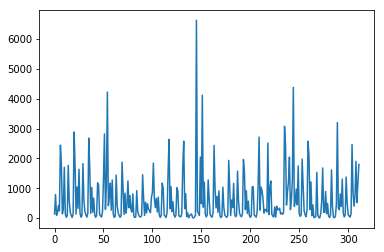

In [49]:
attribute_occurance = np.sum(y_train_attribute,axis=0)
plt.plot(attribute_occurance)
attribute_occurance[128]

In [3]:
## Get Model
from keras.models import load_model
model = load_model('Final network.h5')
feature_maps = Model(inputs = model.input,outputs = model.get_layer('activation_49').output)
global_avg = Model(inputs = model.input,outputs = model.get_layer('global_average_pooling2d_1').output)

In [ ]:
## observation matrix: store the activation history of last conv-layer of the model

i = 0
observation = np.zeros((2048,312))
for img in x_train:# feed all training img into the model and record the activation
    avgs = global_avg.predict(x = img.reshape(1,224,224,3))
    avgs_normalized = np.exp(avgs)/np.sum(np.exp(avgs))
    i += 1
    print(i,end='\r')
np.savetxt("avgs matrix.txt", avgs_matrix)

In [4]:
avgs_matrix = np.loadtxt("avgs matrix.txt") 
np.shape(avgs_matrix)

(10608, 2048)

In [5]:
# normalize the activation matrix
avgs_matrix_1 = np.exp(avgs_matrix)/np.sum(np.exp(avgs_matrix),axis=0)
avgs_matrix_2 = np.exp(avgs_matrix_1)/np.sum(np.exp(avgs_matrix_1),axis=1)[:,np.newaxis]

In [7]:
# Compute observation matrix (filter|attribute probability)
observation = np.zeros((2048,312))
for i in range(10608):
    avgs = avgs_matrix_1[i,:]
    avgs_normalized = np.exp(avgs)/np.sum(np.exp(avgs))
    observation_i =(avgs_normalized).reshape(2048,1)*(y_train_attribute[i,:].reshape(1,312))
    observation = observation_i+observation
    i += 1
    print(i,end='\r')

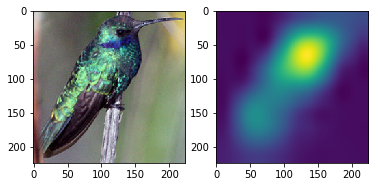

In [70]:
img_ind =[]
x = 0
target_feature = 128# the feature that we want to plot

for i in y_train_attribute[:,target_feature]:# extract all images that have the target feature
    if i==1:
        img_ind.append(x)
    x+=1
i = 0

for img in x_train[img_ind]:
    if i ==25:# we select a random image that has target feature for demonstration, here we selected the 25th
        img_test = img
    i+=1
# feed the selected image into the model and collect the feature maps.
maps = feature_maps.predict(x = img_test.reshape(1,224,224,3))

# create the image mask 
final_mask = np.dot(np.reshape(maps,(7,7,2048)),observation[:,target_feature])/np.sum(observation[:,target_feature])
mask = cv.resize(final_mask,None,fx=224/7,fy=224/7,interpolation = cv.INTER_CUBIC)
# plot the selected image and detected feature region
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img_test)

f.add_subplot(1,2, 2)
plt.imshow(mask)
plt.show(block=True)